# Bike Sharing System - D.C.

**Background:** Rental Bike Systems have become popular in major U.S. cities, 
especially Washington DC. These systems involve users renting a bike from a
particular position and returning back to another position. However, these bikes
need repairments to ensure they're properly working. To maximize sales, rental 
bike companies want to repair those bikes on a day with a low # of rentals. 
However, bike rentals varies on several different factors.

**Objective:** Predict the total count of bikes rented during each hour

The training dataset is a per hour catalog of day, weather, and bike rentals 
data over the first 19 days in every month in a 2 year period, meaning there is
no duplicate rows. The testing data is the per hour catalog over the remaining 
days of those months.

In this notebook, I used ...

In [981]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [982]:
# Load data
df = pd.read_csv('train_bikes.csv')
test_df = pd.read_csv('test_bikes.csv')

## Exploratory Data Analysis

**Goal:** Analyze and summarize the main characteristics of this dataset

In [983]:
# Check the Shape of the Dataset
print(f"Dimensions of Dataset: {df.shape}")


Dimensions of Dataset: (10886, 12)


In [984]:
# View some of the Dataset
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [985]:
# Check the Datatypes and Non-Null Counts of each Feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Takeaways from Above
- There are no null values, as each feature has the max # of non-null values.
- `casual` or `registered` rentals aren't needed, as those features can
derive the target variable, `count` (`count` = `casual` + `registered`).
  - **Note:** In practicality, the model will be used to predict future total 
  bike rentals, so it won't have future casual and registered rentals beforehand.
- `datetime` is currently a string of various information. It should rather be 
broken down into several int64 columns that can be more useful to the model.
- Categorical values `season` and `weather` are currently label encoded. 
However, a machine learning algorithm may assume the labels have an ordered 
relationship when there isn't. The weather with type 1 (sunny) is equally 
different from the remaining weather types despite being numerically closer to 
2 (cloudy). I need to encode this variable differently in my data preprocessing.
- The remaining features are in the correct datatypes and can provide useful 
information to predict the # of bike rentals.

In [986]:
# Remove # of Casual and Registered Rentals
df.drop(columns=['casual', 'registered'], inplace=True)

In [987]:
# View Updated Data
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


### Analysis of Target Variable
The goal of this section is to analyze the distribution of the target variable, 
`count`, by visualizations like a histogram. This will allow me to notice any 
skewness in the data and fix it in data preprocessing.This variable represents
the number of bike rentals per hour. 

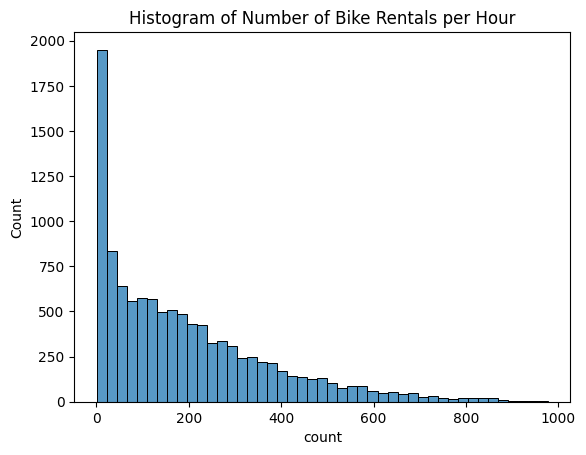

In [988]:
# Visualize distribution of target variable using histogram
sns.histplot(data=df, x='count')
plt.title("Histogram of Number of Bike Rentals per Hour")
plt.show()

Takeaways from Above:
- The target variable is heavily skewed right. This imbalance in data might 
prove to be a problem later on.

### Analysis of Features

The goal of this section is to analyze the distribution of all of the features
and see how bike rentals per hour change based off of that feature.

This section is later broken down into 2 sub-sections, `Categorical` and 
`Numerical`, where we analyze the 2 types of variables.

We'll start off by looking at correlations between the features through a heat
map and a top correlation list to see which features are highly correlated 
together. This will be useful later when we perform dimension reduction and open
the door for algorithms that have problems with feature that have high-colinearity.

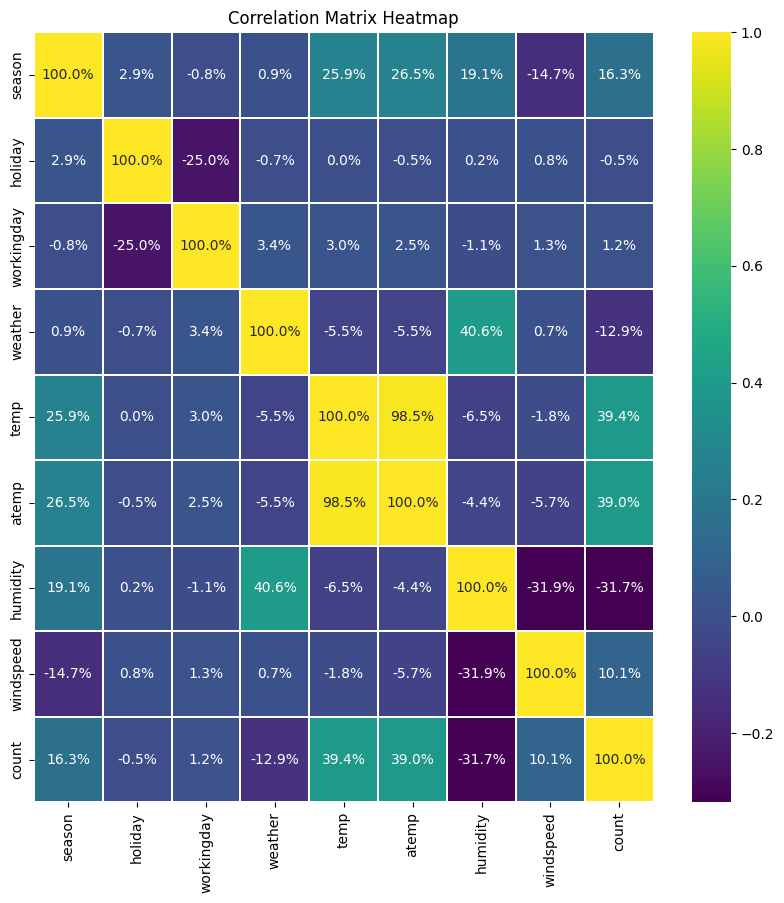

In [989]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.01, fmt='.1%')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [990]:
# Retrieve DataFrame of Correlations with a Threshold of 0.9
corr_unstacked = corr_matrix.unstack()
top_corr = corr_unstacked.reindex(corr_unstacked.abs().sort_values(\
    ascending=False).index)
top_corr = top_corr[(0.9 <= corr_unstacked) & (corr_unstacked != 1)].reset_index()
top_corr.columns = ['Row', 'Column', 'Abs. Correlation']
top_corr

,Row,Column,Abs. Correlation
0,atemp,temp,0.984948
1,temp,atemp,0.984948


Takeaways from Above
- Temperature (`temp`) and apparent temperature (`atemp`) are very highly 
correlated.


#### Categorical Features

This section analyzes the distribution of all of the categorical features. I'll 
see how the feature is distributed and how bike rentals per hour change based 
off of changes in the feature through bar charts. This will help me detect 
imbalances in the dataset and see any patterns with the target variable, # of 
bike rentals per hour.

In [991]:
# Helper Function to Add Labels to Bars in Bar Charts
def add_labels(axes, num):
    for p in axes[num].patches:
        axes[num].annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()/3), 
            ha = 'center', 
            va = 'center', 
            xytext = (0, 9), textcoords = 'offset points'
        )

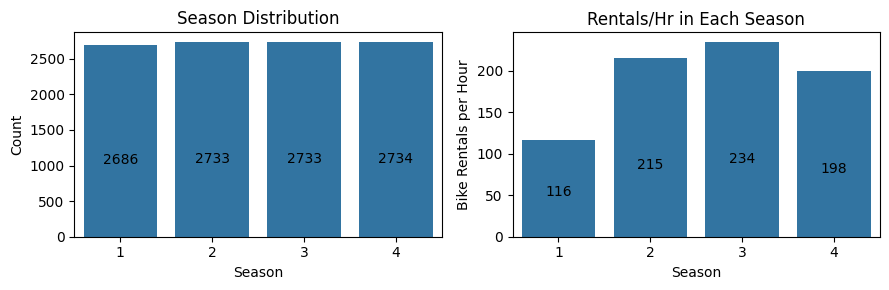

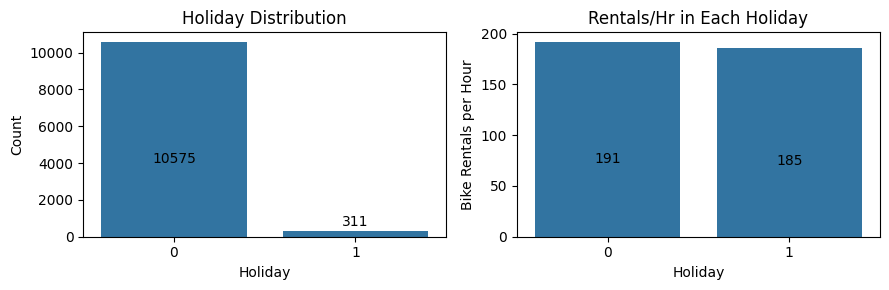

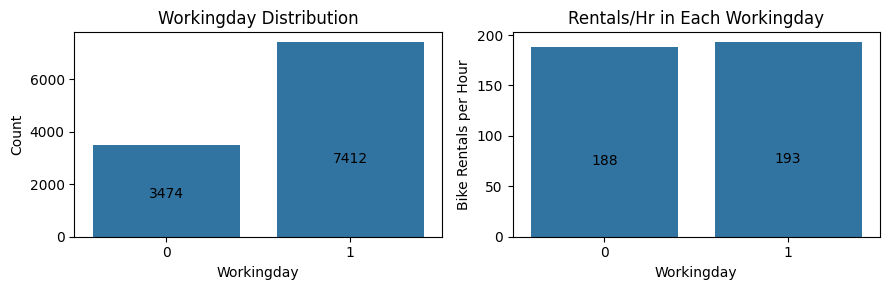

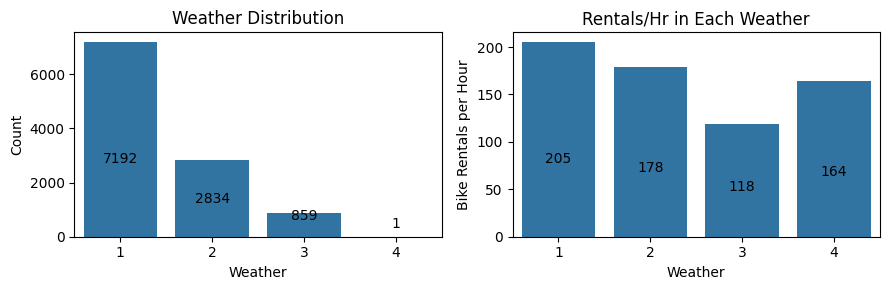

In [992]:
# Visualize Distribution of Categorical Features
categorical = ['season', 'holiday', 'workingday', 'weather']
for column in categorical:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))

    # Figure #1: Bar Chart of the Categorical Feature Counts
    sns.countplot(data=df, x=column, ax=axes[0])
    axes[0].set_xlabel(column.capitalize())
    axes[0].set_ylabel('Count')
    axes[0].set_title(f"{column.capitalize()} Distribution")
    add_labels(axes, 0)

    # Figure #2: Bar Chart of the Categrocial Feature vs Bike Rentals per hour
    percentages = df.groupby(column, sort=False)['count'].mean().reset_index()
    sns.barplot(data=percentages, x=column, y='count', ax=axes[1])
    axes[1].set_xlabel(column.capitalize())
    axes[1].set_ylabel('Bike Rentals per Hour')
    axes[1].set_title(f"Rentals/Hr in Each {column.capitalize()}")
    add_labels(axes, 1)

    plt.tight_layout() 
    plt.show()

Takeaways from Above:
- There is a significant imbalance in `holiday`, `working day`, and `weather` in
this dataset, while `season` is perfectly balanced.
- Both `weather` and `season` play significant roles in bike rental patterns. Analysis indicates
the following:
  - Summer, with a value of 3, is the peak `season` for bike rentals,
whereas winter, with a value of 1, is the least popular.
  - Sunny days, with a value of 1, is the most popular `weather` for bike rentals,
whereas rainy days, with a value of 3, is the least popular.
  - Snowy days are extremely uncommon: one hour for the entire year. This can 
  prove to be a big problem for our model, as that one day had a high # of bike
  rentals.
  - Both features have no inherent order, so both should be encoded from
  numerical to their respective string values.
- Whether the day is a `holiday` or a `working day` doesn't have much impact on 
bike rentals per hour that much.

#### Numerical Features

This section analyzes the distribution of all of the numerical features. I'll 
see how the feature is distributed, how bike rentals per hour change based 
off of changes in the feature, and how many outliers are there through a 
histogram, color mesh, and box plot respectively. This will allow me to detect
any imbalances in any of the features and give me insight on future feature 
engineering.

In [993]:
# Look at Summary Statistics of Numerical Features
numerical = ['temp', 'atemp', 'humidity','windspeed']
df[numerical].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


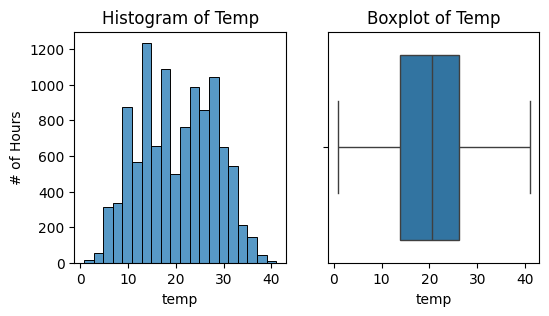

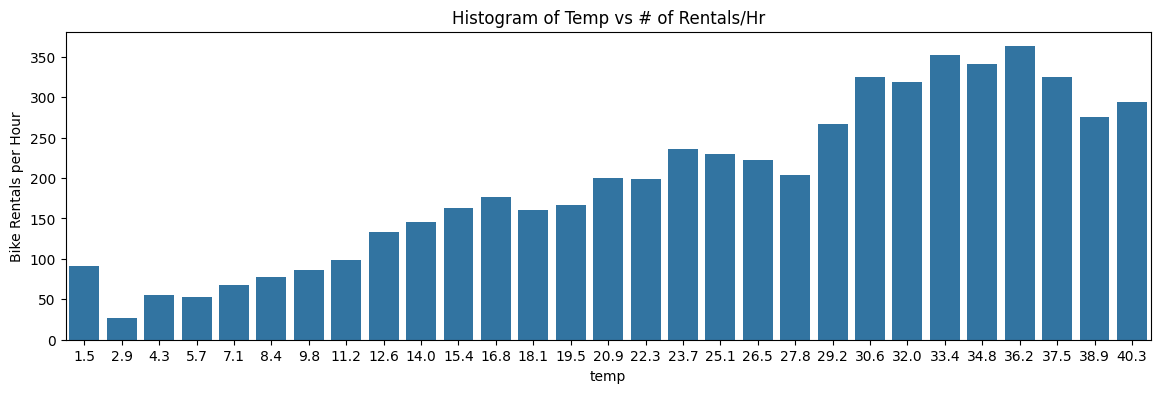

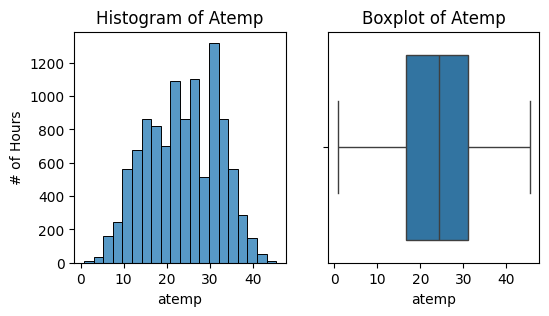

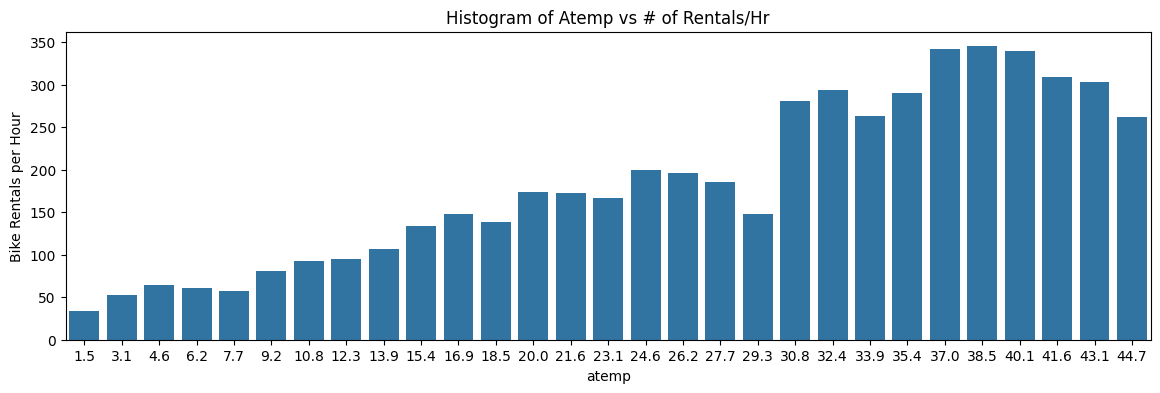

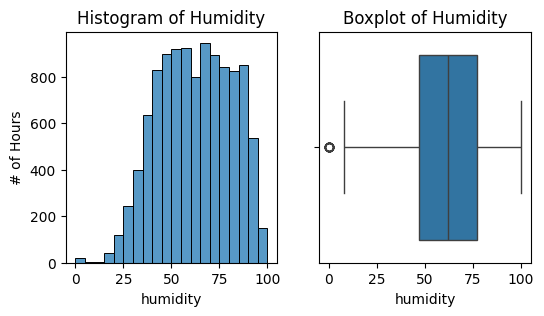

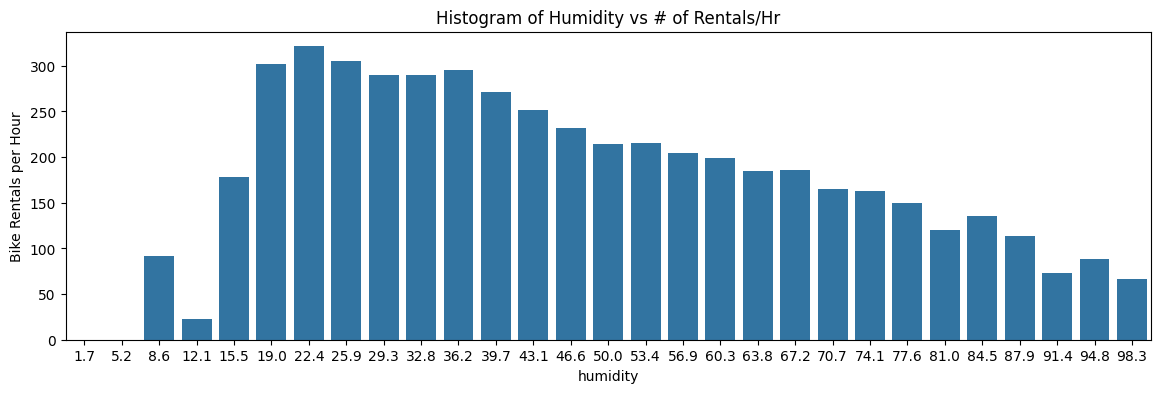

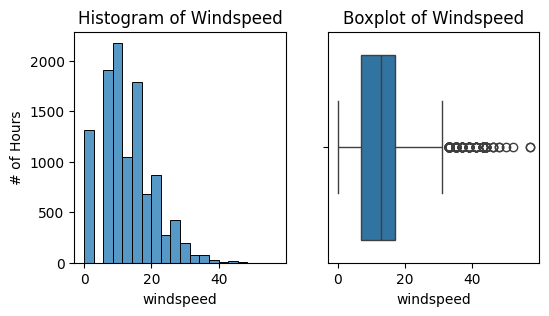

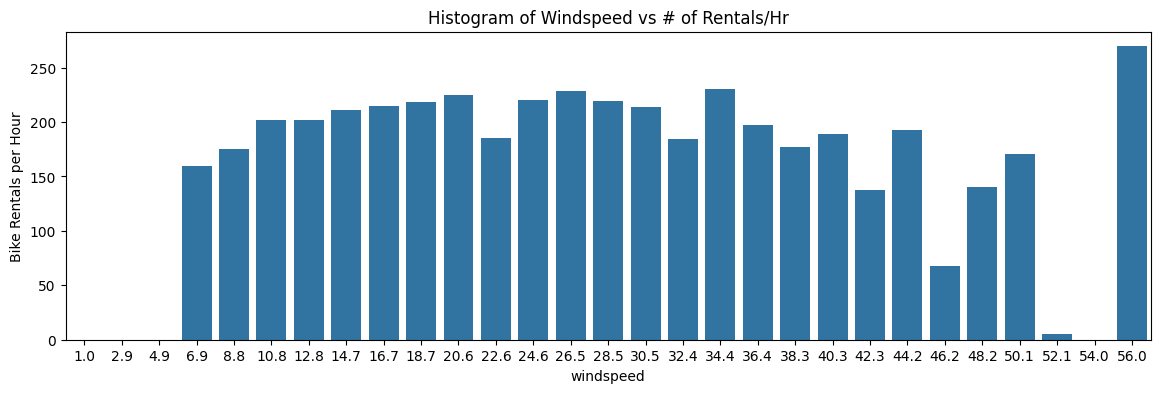

In [994]:
# Visualize the Distribution of Numerical Variables
for column in numerical:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Figure #1: Histogram of Numerical Feature
    sns.histplot(data=df, x=column, bins=20, ax=axes[0])
    axes[0].set_ylabel("# of Hours")
    axes[0].set_title(f"Histogram of {column.capitalize()}")

    # Figure #2: Boxplot of Numerical Feature
    sns.boxplot(data=df, x=column, ax=axes[1])
    axes[1].set_title(f"Boxplot of {column.capitalize()}")
    plt.show()

    # Figure #3: Histogram of Numerical Feature vs # of Rentals/Hr
    max_x = df[column].max()
    x_bins = np.linspace(df[column].min(), max_x, 30)
    bin_summary = df.groupby(pd.cut(df[column], bins=x_bins),observed=False)['count'].mean().reset_index()
    bin_summary[column] = bin_summary[column].apply(lambda x: round(x.mid, 1))
    plt.figure(figsize=(14,4))
    sns.barplot(data=bin_summary, x=column, y='count')
    plt.ylabel("Bike Rentals per Hour")
    plt.title(f"Histogram of {column.capitalize()} vs # of Rentals/Hr")
    plt.show()


Takeaways from Above Summary Statistics and Visualizations
- `windspeed` data is skewed right with several outliers of extreme high 
windspeeds. The remaining features are approximately normally distributed with 
few outliers.
- Temperature (`temp`) and apparent temperature (`atemp`) have very similar 
distributions, which was expected from the correlation analysis before.
  - Both show that there are more bike renters when there is warmer weather, 
  which corroraborates with our takeaways earlier.
- `humidity` indicates that people are renting less bikes when it's more humid
outside. This is most likely high humditiy is usually caused by recent rainfall,
which indicate that the sidewalks wet.
- Bikers seem indifferent on `windspeed` unless it reaches a certain point 
(~ 35 mph).

## Data Preprocessing

The goal of this section is to create features and preprocess the data so the 
future model won't be subject to bias that was in the dataset beforehand.

### Feature Engineering
Earlier, I recognzied `datatime` was a string of information rather than several
int64 entries. To utilize `datetime`, I'm going to break it down into `time` and 
`month`, where both would be int64 and provide unique information to the dataset
that could be useful. 

Note: I am not breaking `datetime` down into the following data because...
  - `year`: the model should be generalizable to future years
  - `minutes`: The dataset is hourly data, so minutes would always be 0

In [995]:
# Breaking Down Datetime into month and hour
df[['month', 'hour']] = df['datetime'].str.split(expand=True)
df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))
df['hour'] = df['hour'].apply(lambda x: int(x.split(':')[0]))
df.drop(columns=['datetime'], inplace=True) # Deleting Datetime

# Apply the same feature engineering on testing dataset
test_df[['month', 'hour']] = test_df['datetime'].str.split(expand=True)
test_df['month'] = test_df['month'].apply(lambda x: int(x.split('-')[1]))
test_df['hour'] = test_df['hour'].apply(lambda x: int(x.split(':')[0]))
test_df.drop(columns=['datetime'], inplace=True) # Deleting Datetime

For month and hour, I don't need the count bar chart, as it will be uniform. 
I, instead, want a bar chart with the bike rentals per hour to see how it varies
based off month or hour.

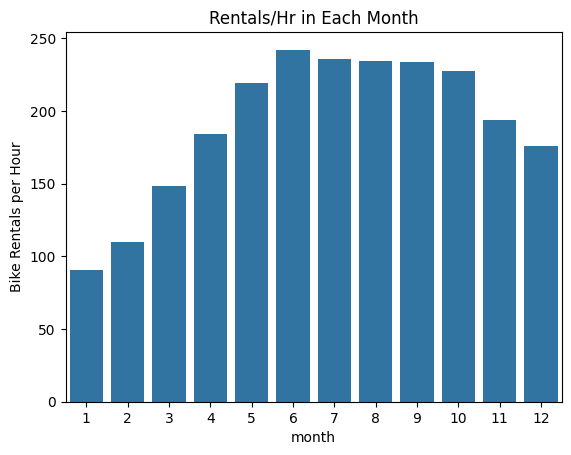

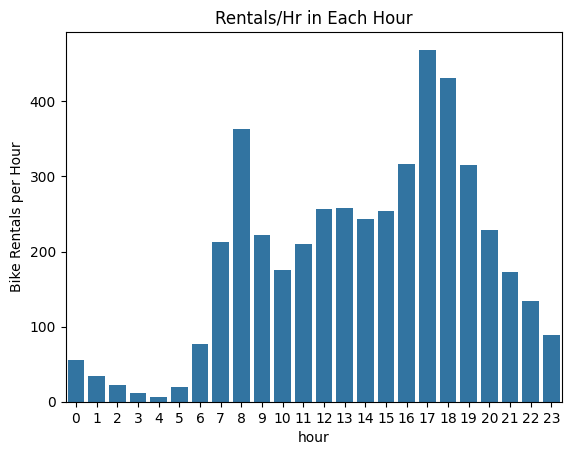

In [996]:
# Visualize how Bike Rentals per Hour changes based off month or hour
for column in ['month', 'hour']:
    perecentages = df.groupby(column)['count'].mean().reset_index()
    sns.barplot(data=perecentages, x=column, y='count')
    plt.ylabel('Bike Rentals per Hour')
    plt.title(f"Rentals/Hr in Each {column.capitalize()}")
    plt.show()

Takeaways from Above
- There are higher # of bike rentals per hour during months with warmer
weather (May-September) than those with cooler weather.
- People rent bikes during the daytime rather than night time.
- Bike Rentals are most popular during rush hours (7-9 am and 4-6 pm).

From the above analysis, `temp` and `atemp` have a 0.985 correlation and have 
nearly identical distributions. Because of this, we only need one of these 
variables in our model.

In [997]:
# Drop atemp from our dataset
df.drop(columns=['atemp'], inplace=True)
test_df.drop(columns=['atemp'], inplace=True)

### Encoding Categorical Data
As mentioned earlier, categorical features `season` and `weather` are currently 
label encoded. However, I want to avoid the proximinity of numbers affecting the
model, as both features have no inherent order. For instance, the weather with type
1 (sunny) is equally different from the remaining weather types despite being
numerically closer to 2 (cloudy).

To fix this, I plan to re-encode the categorical features, as machine learning 
methods work with numbers, not text. Since the cardinality of the two features 
is only four, I plan to re-encode the features using Dummy Encoding. I will drop
the first category (`Winter` and `Sunny` respecitvely) in both to avoid multi-colinearity.

In [998]:
# Perform dummy encoding on the two categorical features
one_hot1 = pd.get_dummies(df['season'], dtype='int', drop_first=True)
one_hot2 = pd.get_dummies(df['weather'], dtype='int', drop_first=True)

# Same thing but for testing dataset
one_hot3 = pd.get_dummies(test_df['season'], dtype='int', drop_first=True)
one_hot4 = pd.get_dummies(test_df['weather'], dtype='int', drop_first=True)

In [999]:
# Rename columns to represent the actual season/weather
one_hot1.columns = one_hot3.columns = ["Spring", "Summer", "Fall"]
one_hot2.columns = one_hot4.columns = ["Cloudy", "Rainy", "Snowy"]

In [1000]:
# Concatenate the dummy encoding with the original dataframe
df = pd.concat([df, one_hot1, one_hot2], axis=1)
test_df = pd.concat([test_df, one_hot3, one_hot4], axis=1)

# Drop the original columns
df.drop(labels=['season', 'weather'], axis=1, inplace=True)
test_df.drop(labels=['season', 'weather'], axis=1, inplace=True)

df.head()

,holiday,workingday,temp,humidity,windspeed,count,month,hour,Spring,Summer,Fall,Cloudy,Rainy,Snowy
0,0,0,9.84,81,0.0,16,1,0,0,0,0,0,0,0
1,0,0,9.02,80,0.0,40,1,1,0,0,0,0,0,0
2,0,0,9.02,80,0.0,32,1,2,0,0,0,0,0,0
3,0,0,9.84,75,0.0,13,1,3,0,0,0,0,0,0
4,0,0,9.84,75,0.0,1,1,4,0,0,0,0,0,0


### Dealing with the Skewness of Target Variable

As mentioned above, the target variable, `count`, is skewed right. This can pose
a problem in our regression models, introducing bias towards lower counts of 
bike rentals per hour. To address this, I will apply a log transformation of
the target variable.

In [1001]:
# Apply log transformation
df['log_count'] = np.log(df['count'])
#df['log_count'] = np.sqrt(np.sqrt(df['count']))
#df['log_count'] = df['count']

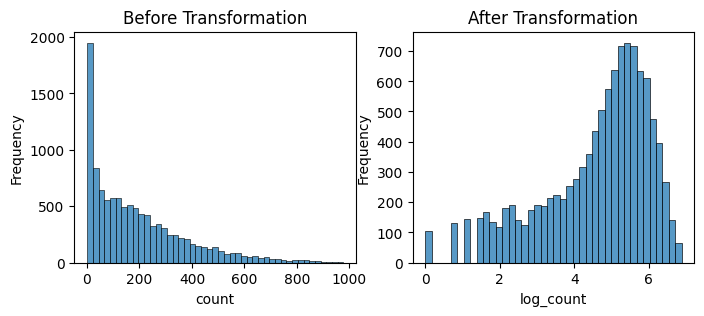

In [1002]:
# Visualize distribution of target variable using histogram
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(data=df, x='count', ax=axes[0])
sns.histplot(data=df, x='log_count', ax=axes[1])
axes[0].set_title("Before Transformation")
axes[0].set_ylabel("Frequency")
axes[1].set_title("After Transformation")
axes[1].set_ylabel("Frequency")
plt.show()

## Linear Regression

I'll first start off with the simplest model, a Linear Regression Model. This
problem doesn't fully satisfy all of the assumptions, as each hour's data isn't
independent of each other. Since they're consecutive hours of 2 years, the hours
near each other chronologically will have similar # of bike rentals, weather, 
etc. Also, features are highly correlated together, such as temperature and
season.

However, I'll still check out this type of model to see any patterns.

In [1003]:
# Prepare input and output data 
x_train = df.drop(['count', 'log_count'], axis=1)
y_train = df['log_count']

# Since there is no label in testing data, x_test is just the dataframe
x_test = test_df 

In [1004]:
# Train the model
model = LinearRegression().fit(x_train, y_train)

In [1005]:
# See the weights and bias of the linear regression model
print(f"intercept: {model.intercept_}")
coef_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': model.coef_
})
coef_df

intercept: 2.7241308614283826


,Feature,Coefficient
0,holiday,-0.065327
1,workingday,-0.103474
2,temp,0.063657
3,humidity,-0.014969
4,windspeed,0.002331
5,month,0.071177
6,hour,0.100898
7,Spring,-0.061615
8,Summer,-0.441038
9,Fall,-0.068796


In [1006]:
# Make predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(test_df)

In [1007]:
# Evaluate the model using r^2 and mean squared error
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"Coefficient of determination (r^2): {r2_train}")
print(f"Mean Squared Error (MSE): {mse_train}")

Coefficient of determination (r^2): 0.47051532583957256
Mean Squared Error (MSE): 1.1738912816744105


Takeaways from Above:
- Linear Regression didn't perform that well, with a low r-squared value and
a moderately high Mean Squared Error.
- The coefficients for some of the features are low, with the exception of 
snowy days.